In [1]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, train_test_split
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade, EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier
import warnings
from itable import PrettyTable
import pandas as pd
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Generate data with two classes
X, y = make_classification(class_sep=1.2, weights=[0.1, 0.9], n_informative=3, 
                           n_redundant=1, n_features=5, n_clusters_per_class=1, 
                           n_samples=10000, flip_y=0, random_state=10)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

y = y.astype('str')
y[y=='1'] ='L'
y[y=='0'] ='S'

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                    random_state=0)

X_1, X_2 = X_train[y_train=='S'], X_train[y_train=='L']

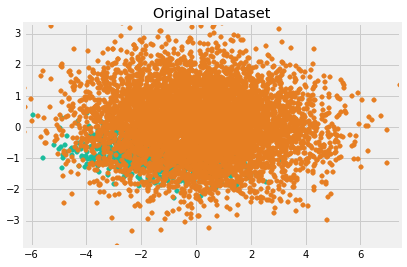

In [3]:
# Scatter plot of the data
plt.scatter(zip(*X_1)[0], zip(*X_1)[1], color='#1abc9c')
plt.scatter(zip(*X_2)[0], zip(*X_2)[1], color='#e67e22')

x_coords = zip(*X_1)[0] + zip(*X_2)[0]
y_coords = zip(*X_1)[1] + zip(*X_2)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Original Dataset")
plt.show()

In [4]:
# Fit a Logistic Regression model
clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train, y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

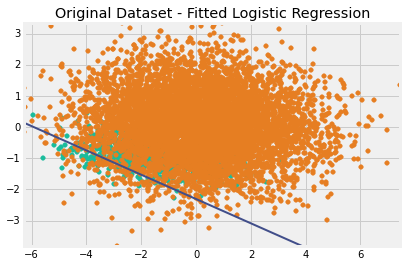

In [5]:
plt.scatter(zip(*X_1)[0], zip(*X_1)[1], color='#1abc9c')
plt.scatter(zip(*X_2)[0], zip(*X_2)[1], color='#e67e22')

x_coords = zip(*X_1)[0] + zip(*X_2)[0]
y_coords = zip(*X_1)[1] + zip(*X_2)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Original Dataset - Fitted Logistic Regression")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [6]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.90      0.98      0.94      2680
          S       0.39      0.12      0.19       320

avg / total       0.85      0.89      0.86      3000



In [7]:
# Logistic Regression with balanced class weights
clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2'],
        'class_weight': ['balanced']}

cv = KFold(X_train.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train, y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

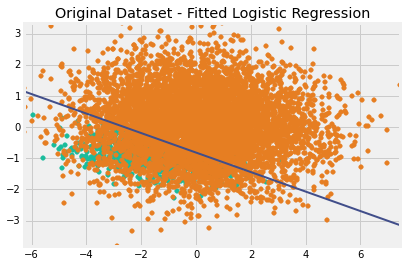

In [8]:
x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

plt.scatter(zip(*X_1)[0], zip(*X_1)[1], color='#1abc9c')
plt.scatter(zip(*X_2)[0], zip(*X_2)[1], color='#e67e22')

x_coords = zip(*X_1)[0] + zip(*X_2)[0]
y_coords = zip(*X_1)[1] + zip(*X_2)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Original Dataset - Fitted Logistic Regression")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [9]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.98      0.79      0.88      2680
          S       0.34      0.89      0.49       320

avg / total       0.92      0.80      0.84      3000



In [10]:
# Random undersampling of majority class
us = RandomUnderSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 1360, 'S': 680})


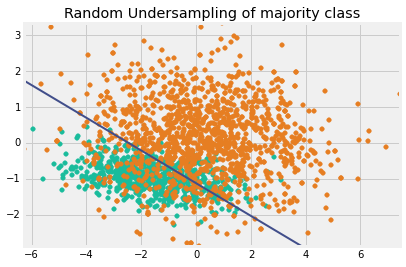

In [11]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Random Undersampling of majority class")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [12]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.97      0.83      0.90      2680
          S       0.36      0.82      0.50       320

avg / total       0.91      0.83      0.85      3000



In [13]:
# Near Miss 1
us = NearMiss(ratio=0.5, size_ngh=3, version=1, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 1360, 'S': 680})


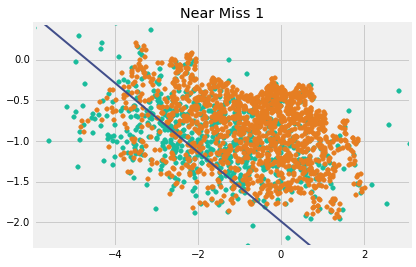

In [14]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Near Miss 1")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [15]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.92      0.95      0.94      2680
          S       0.44      0.32      0.37       320

avg / total       0.87      0.88      0.88      3000



In [16]:
# Near Miss 2
us = NearMiss(ratio=0.5, size_ngh=3, version=2, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 1360, 'S': 680})


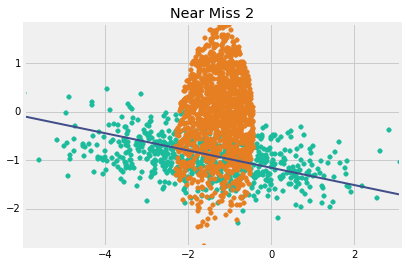

In [17]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Near Miss 2")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [18]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.95      0.89      0.92      2680
          S       0.39      0.60      0.47       320

avg / total       0.89      0.86      0.87      3000



In [19]:
# Near Miss 3
us = NearMiss(ratio=0.5, size_ngh=3, ver3_samp_ngh=3, version=3, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 964, 'S': 680})


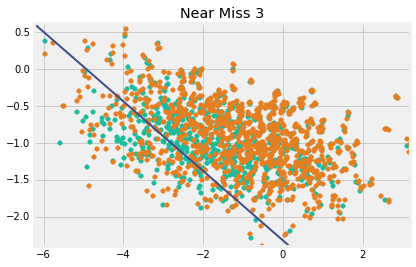

In [20]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Near Miss 3")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [21]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.91      0.97      0.94      2680
          S       0.43      0.20      0.28       320

avg / total       0.86      0.89      0.87      3000



In [22]:
# Condensed Nearest Neighbor
us = CondensedNearestNeighbour(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 882, 'S': 680})


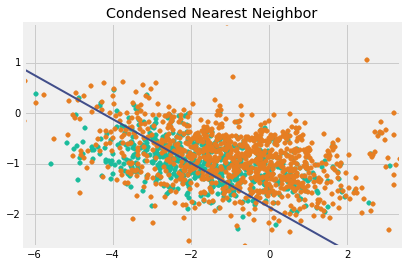

In [23]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Condensed Nearest Neighbor")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [24]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.93      0.94      0.93      2680
          S       0.44      0.39      0.42       320

avg / total       0.88      0.88      0.88      3000



In [25]:
# Edited Nearest Neighbor (ENN)
us = EditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 5120, 'S': 680})


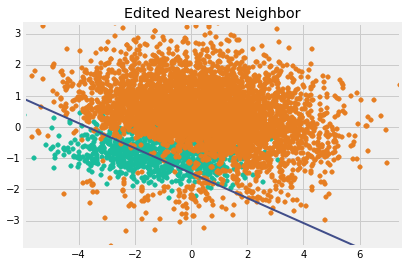

In [26]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Edited Nearest Neighbor")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [27]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.95      0.90      0.92      2680
          S       0.42      0.59      0.49       320

avg / total       0.89      0.87      0.88      3000



In [28]:
# Repeated Edited Nearest Neighbor
us = RepeatedEditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 4796, 'S': 680})


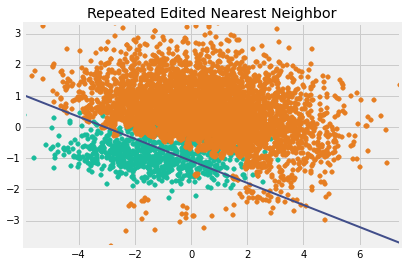

In [29]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Repeated Edited Nearest Neighbor")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [30]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.97      0.84      0.90      2680
          S       0.38      0.80      0.51       320

avg / total       0.91      0.84      0.86      3000



In [31]:
# Tomek link removal
us = TomekLinks(random_state=1)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 6051, 'S': 680})


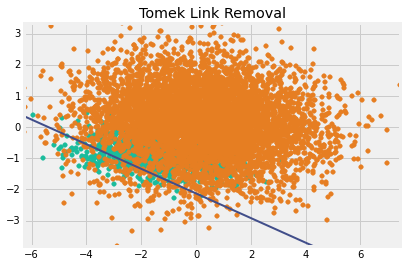

In [32]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Tomek Link Removal")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [33]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.91      0.97      0.94      2680
          S       0.44      0.21      0.29       320

avg / total       0.86      0.89      0.87      3000



In [34]:
# Random oversampling of minority class
os = RandomOverSampler(ratio=0.5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 6320, 'S': 3160})


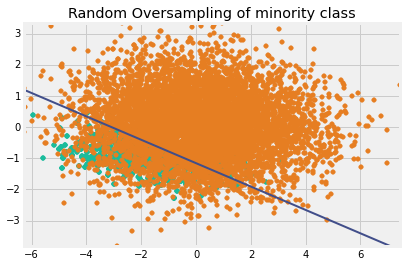

In [35]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("Random Oversampling of minority class")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [36]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.97      0.85      0.91      2680
          S       0.38      0.76      0.51       320

avg / total       0.91      0.84      0.86      3000



In [37]:
# Synthetic Minority Oversampling Technique (SMOTE)
os = SMOTE(ratio=0.5, k=5, random_state=1)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 6320, 'S': 3160})


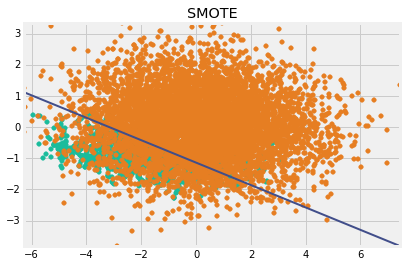

In [38]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("SMOTE")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [39]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.97      0.85      0.91      2680
          S       0.38      0.77      0.51       320

avg / total       0.91      0.84      0.86      3000



In [40]:
# SMOTE + Tomek link removal
os_us = SMOTETomek(ratio=0.5, k=5, random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 6050, 'S': 3160})


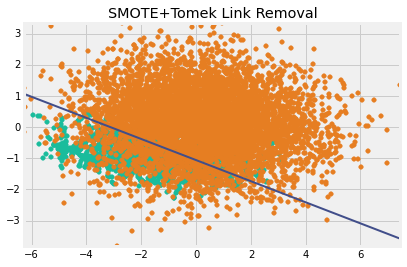

In [41]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("SMOTE+Tomek Link Removal")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [42]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.97      0.84      0.90      2680
          S       0.38      0.80      0.51       320

avg / total       0.91      0.84      0.86      3000



In [43]:
# SMOTE + ENN
os_us = SMOTEENN(ratio=0.5, k=5, size_ngh=5, random_state=1)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print "Distribution of class labels before resampling {}".format(Counter(y_train))
print "Distribution of class labels after resampling {}".format(Counter(y_train_res))

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2']}

cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train_res, y_train_res)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_

x1 = np.linspace(-8, 10, 100)
x2 = -(coef[0][0] * x1 + intercept[0]) / coef[0][1]

X_1_res = X_train_res[y_train_res=='S']
X_2_res = X_train_res[y_train_res=='L']

Distribution of class labels before resampling Counter({'L': 6320, 'S': 680})
Distribution of class labels after resampling Counter({'L': 4894, 'S': 3160})


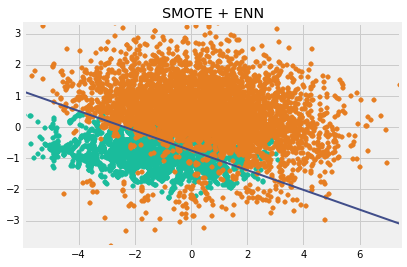

In [44]:
plt.scatter(zip(*X_1_res)[0], zip(*X_1_res)[1], color='#1abc9c')
plt.scatter(zip(*X_2_res)[0], zip(*X_2_res)[1], color='#e67e22')

x_coords = zip(*X_1_res)[0] + zip(*X_2_res)[0]
y_coords = zip(*X_1_res)[1] + zip(*X_2_res)[1]
plt.axis([min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.title("SMOTE + ENN")
plt.plot(x1, x2, color='#414e8a', linewidth=2)
plt.show()

In [45]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          L       0.99      0.78      0.87      2680
          S       0.33      0.92      0.49       320

avg / total       0.92      0.79      0.83      3000



In [46]:
# EasyEnsemble
ens = EasyEnsemble()
X_train_res, y_train_res = ens.fit_sample(X_train, y_train)

y_pred_proba = np.zeros(len(y_test))
for idx in range(len(y_train_res)):
    clf_base = AdaBoostClassifier()
    grid = {'n_estimators': [10, 50, 100]}

    cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
    clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
    clf.fit(X_train_res[idx], y_train_res[idx])
    y_pred_proba += zip(*clf.predict_proba(X_test))[0]
    
y_pred_proba = y_pred_proba/len(y_train_res)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = y_pred.astype('str')
y_pred[y_pred=='1'] ='L'
y_pred[y_pred=='0'] ='S'

In [47]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          L       0.98      0.80      0.88      2680
          S       0.34      0.88      0.49       320

avg / total       0.91      0.81      0.84      3000



In [48]:
# BalanceCascade

# Note this is not a true implementation of BalancaCacade since the library
# does not return the fitted classifiers used in generating the subsets
ens = BalanceCascade(classifier='adaboost', random_state=1)
X_train_res, y_train_res = ens.fit_sample(X_train, y_train)

y_pred_proba = np.zeros(len(y_test))
for idx in range(len(y_train_res)):
    # imblearn uses AdaBoostClassiifer with default hyperparams to select subsets
    # a variant implementation with grid search for each subsample is shown in the next cell
    clf = AdaBoostClassifier(random_state=1)
    clf.fit(X_train_res[idx], y_train_res[idx])
    y_pred_proba += zip(*clf.predict_proba(X_test))[0]
    
y_pred_proba = y_pred_proba/len(y_train_res)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = y_pred.astype('str')
y_pred[y_pred=='1'] ='L'
y_pred[y_pred=='0'] ='S'

In [49]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          L       0.99      0.81      0.89      2680
          S       0.36      0.91      0.51       320

avg / total       0.92      0.82      0.85      3000



In [50]:
# Note this is not a true implementation of BalancaCacade since the library
# does not return the fitted classifiers used in generating the subsets
ens = BalanceCascade(classifier='adaboost', random_state=1)
X_train_res, y_train_res = ens.fit_sample(X_train, y_train)

y_pred_proba = np.zeros(len(y_test))
for idx in range(len(y_train_res)):
    clf_base = AdaBoostClassifier(random_state=1)
    grid = {'n_estimators': [10, 50, 100]}
    cv = KFold(X_train_res.shape[0], n_folds=5, shuffle=True, random_state=0)
    clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')
    clf.fit(X_train_res[idx], y_train_res[idx])
    y_pred_proba += zip(*clf.predict_proba(X_test))[0]
    
y_pred_proba = y_pred_proba/len(y_train_res)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = y_pred.astype('str')
y_pred[y_pred=='1'] ='L'
y_pred[y_pred=='0'] ='S'

In [51]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          L       0.99      0.80      0.88      2680
          S       0.35      0.90      0.50       320

avg / total       0.92      0.81      0.84      3000

